In [1]:
#This file analyzes the original-remake pairs data prepared in the two previous notebooks.

from __future__ import division
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

In [2]:
#Import movie pairs data
movies = pd.read_csv('data_files/paired_movies.csv', index_col=0)
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529 entries, 0 to 528
Data columns (total 61 columns):
Title_orig                 529 non-null object
Year_orig                  529 non-null int64
imdbRating_orig            517 non-null float64
imdbVotes_orig             517 non-null float64
Runtime_orig               514 non-null float64
Award_count_orig           529 non-null int64
Noms_count_orig            529 non-null int64
Noms+Awards_orig           529 non-null int64
PrimaryCountry_orig        529 non-null object
PrimaryLangFixed_orig      529 non-null object
Crime_orig                 529 non-null int64
Drama_orig                 529 non-null int64
Thriller_orig              529 non-null int64
Action_orig                529 non-null int64
Adventure_orig             529 non-null int64
Film_Noir_orig             529 non-null int64
Mystery_orig               529 non-null int64
Comedy_orig                529 non-null int64
Family_orig                529 non-null int64
Horror_orig 

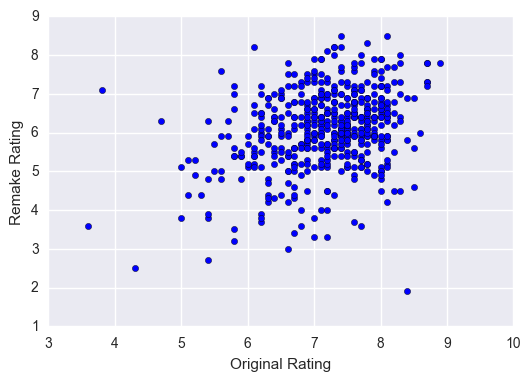

In [3]:
#Visually explore the relationships between a remake's IMDB rating and some of the factors that may influence it
#Original rating vs. remake rating (no obvious nonlinearities here)
plt.scatter(movies.imdbRating_orig, movies.imdbRating_remake)
plt.xlabel('Original Rating')
plt.ylabel('Remake Rating');

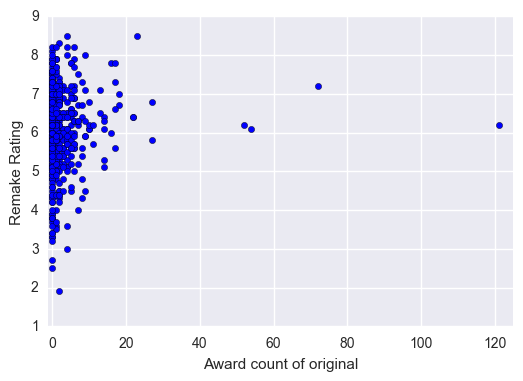

In [4]:
#Original awards vs. remake rating
sns.set_style('darkgrid')
plt.scatter(movies.Award_count_orig, movies.imdbRating_remake)
plt.xlabel('Award count of original')
plt.ylabel('Remake Rating')
plt.xlim(-1, 125);

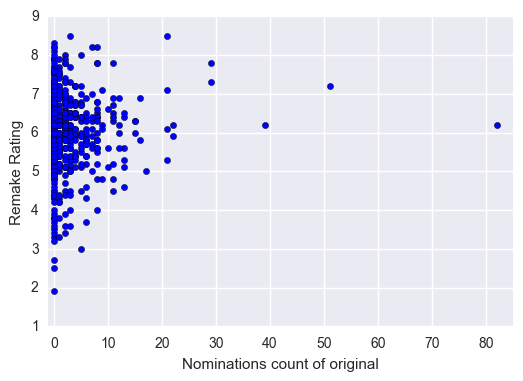

In [5]:
#Original nominations vs. remake rating
plt.scatter(movies.Noms_count_orig, movies.imdbRating_remake)
plt.xlabel('Nominations count of original')
plt.ylabel('Remake Rating')
plt.xlim(-1, 85);

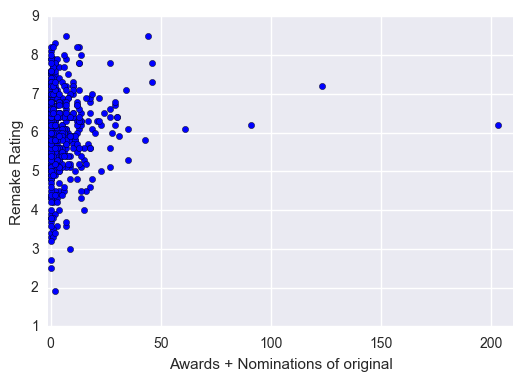

In [6]:
#Original nominations + awards vs. remake rating
plt.scatter(movies['Noms+Awards_orig'], movies.imdbRating_remake)
plt.xlabel('Awards + Nominations of original')
plt.ylabel('Remake Rating')
plt.xlim(-1, 210);

In [7]:
#Pearson correlation between summed noms&awards, and remake ratings
movies.imdbRating_remake.corr(movies['Noms+Awards_orig'])

0.065631697435186945

In [8]:
#What are the 4 big outliers?
movies[movies['Noms+Awards_orig'] > 50]

,Title_orig,Year_orig,imdbRating_orig,imdbVotes_orig,Runtime_orig,Award_count_orig,Noms_count_orig,Noms+Awards_orig,PrimaryCountry_orig,PrimaryLangFixed_orig,...,Music_remake,Fantasy_remake,Western_remake,War_remake,Sport_remake,History_remake,Biography_remake,SameLang,SameCountry,YearDiff
247,Let the Right One In,2008,8.0,177025.0,115.0,72,51,123,Sweden,Swedish,...,0,0,0,0,0,0,0,0,0,2
407,The Secret in Their Eyes,2009,8.2,137289.0,129.0,52,39,91,Argentina,Spanish,...,0,0,0,0,0,0,0,0,0,6
417,Shall We Dance?,1996,7.8,9336.0,136.0,54,7,61,Japan,Japanese,...,0,0,0,0,0,0,0,0,0,8
422,Sideways,2004,7.5,152323.0,126.0,121,82,203,USA,English,...,0,0,0,0,0,0,0,0,0,5


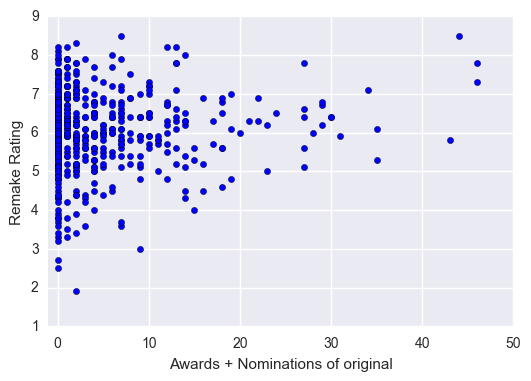

In [9]:
#Look at same relationship without those outliers
plt.scatter(movies['Noms+Awards_orig'], movies.imdbRating_remake)
plt.xlabel('Awards + Nominations of original')
plt.ylabel('Remake Rating')
plt.xlim(-1, 50);

In [10]:
#And what is the correlation without them?
no_award_outliers = movies[movies['Noms+Awards_orig'] < 50]
no_award_outliers.imdbRating_remake.corr(no_award_outliers['Noms+Awards_orig'])

0.075126372499108182

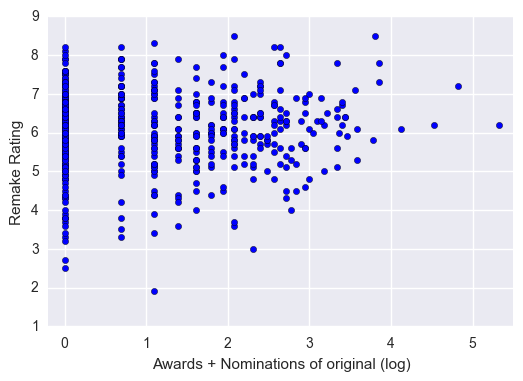

In [11]:
#What does this relationship look like if we do a log transformation on the count of nominations + awards?
plt.scatter(np.log(1 + movies['Noms+Awards_orig']), movies.imdbRating_remake)
plt.xlabel('Awards + Nominations of original (log)')
plt.ylabel('Remake Rating')
plt.xlim(-.2, 5.5);

In [12]:
#Pearson correlation between logged sum of nominations & awards, and remake rating
movies.imdbRating_remake.corr(np.log(1 + movies['Noms+Awards_orig']))

0.047697377815350148

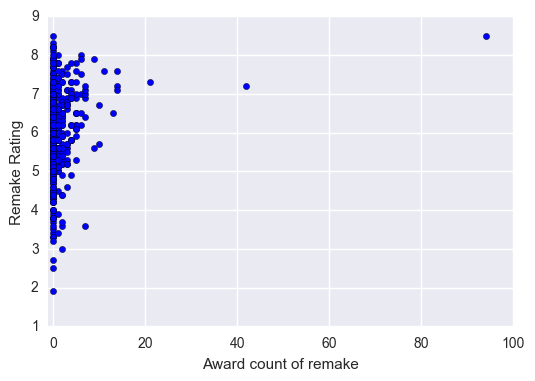

In [13]:
#Next look at the relationship between awards/nominations of the remake and its rating
#Remake awards vs. remake rating
plt.scatter(movies.Award_count_remake, movies.imdbRating_remake)
plt.xlabel('Award count of remake')
plt.ylabel('Remake Rating')
plt.xlim(-1, 100);

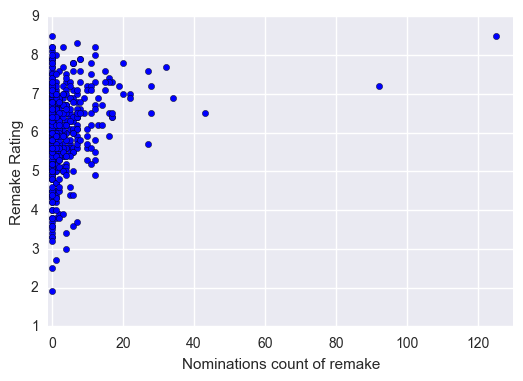

In [14]:
#Remake nominations vs. remake rating
plt.scatter(movies.Noms_count_remake, movies.imdbRating_remake)
plt.xlabel('Nominations count of remake')
plt.ylabel('Remake Rating')
plt.xlim(-1, 130);

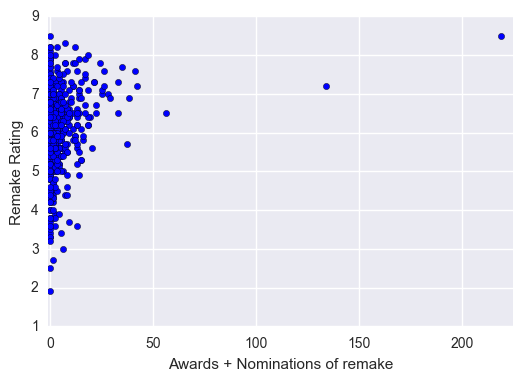

In [15]:
#Remake nominations + awards vs. remake rating
plt.scatter(movies['Noms+Awards_remake'], movies.imdbRating_remake)
plt.xlabel('Awards + Nominations of remake')
plt.ylabel('Remake Rating')
plt.xlim(-1, 225);

In [16]:
#Pearson correlation between sum of nominations & awards of remake, and remake rating
movies.imdbRating_remake.corr(movies['Noms+Awards_remake'])

0.21740114479670214

In [17]:
#What are the 3 big outliers?
pd.set_option('display.max_columns', 61)
movies[movies['Noms+Awards_remake'] > 50]

,Title_orig,Year_orig,imdbRating_orig,imdbVotes_orig,Runtime_orig,Award_count_orig,Noms_count_orig,Noms+Awards_orig,PrimaryCountry_orig,PrimaryLangFixed_orig,Crime_orig,Drama_orig,Thriller_orig,Action_orig,Adventure_orig,Film_Noir_orig,Mystery_orig,Comedy_orig,Family_orig,Horror_orig,Sci_Fi_orig,Romance_orig,Music_orig,Fantasy_orig,Western_orig,War_orig,Sport_orig,History_orig,Biography_orig,Title_remake,Year_remake,imdbRating_remake,imdbVotes_remake,Runtime_remake,Award_count_remake,Noms_count_remake,Noms+Awards_remake,PrimaryCountry_remake,PrimaryLangFixed_remake,Crime_remake,Drama_remake,Thriller_remake,Action_remake,Adventure_remake,Film_Noir_remake,Mystery_remake,Comedy_remake,Family_remake,Horror_remake,Sci_Fi_remake,Romance_remake,Music_remake,Fantasy_remake,Western_remake,War_remake,Sport_remake,History_remake,Biography_remake,SameLang,SameCountry,YearDiff
105,Infernal Affairs,2002,8.1,94333.0,101.0,23,21,44,Hong Kong,Cantonese,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,The Departed,2006,8.5,902849.0,151.0,94,125,219,USA,English,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
231,King Kong,1933,8.0,65280.0,100.0,3,4,7,USA,English,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,King Kong,2005,7.2,321251.0,187.0,42,92,134,New Zealand,English,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,72
503,The War of the Worlds,1953,7.2,25891.0,85.0,5,2,7,USA,English,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,War of the Worlds,2005,6.5,341453.0,116.0,13,43,56,USA,English,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,52


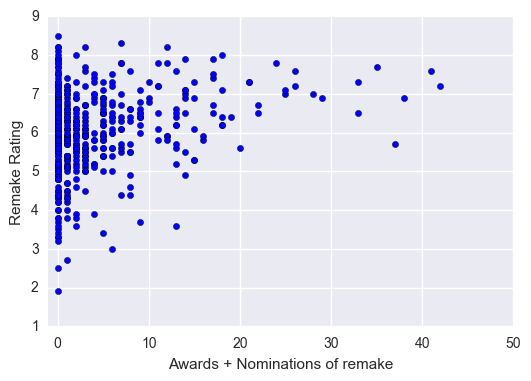

In [18]:
#Again, see what the relationship looks like without them
plt.scatter(movies['Noms+Awards_remake'], movies.imdbRating_remake)
plt.xlabel('Awards + Nominations of remake')
plt.ylabel('Remake Rating')
plt.xlim(-1, 50);

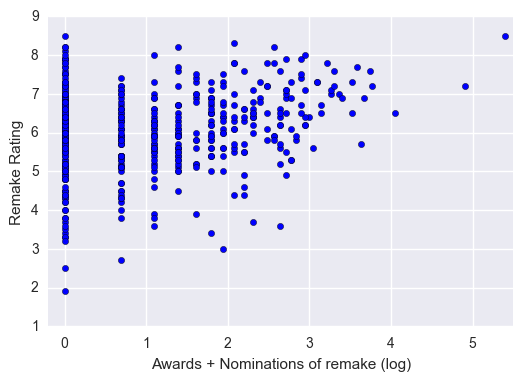

In [19]:
#And check what this relationship looks like if we do a log transformation on the count of nominations + awards:
plt.scatter(np.log(1 + movies['Noms+Awards_remake']), movies.imdbRating_remake)
plt.xlabel('Awards + Nominations of remake (log)')
plt.ylabel('Remake Rating')
plt.xlim(-.2, 5.5);

In [20]:
#Pearson correlation between logged sum of nominations & awards of remake, and remake rating
movies.imdbRating_remake.corr(np.log(1 + movies['Noms+Awards_remake']))

#NOTE: This is interesting, as there's clearly a relationship there, but it really shouldn't go into a model designed to provide insight into the remake ratings,
#since causality could go any of several ways.

0.20641217715126459

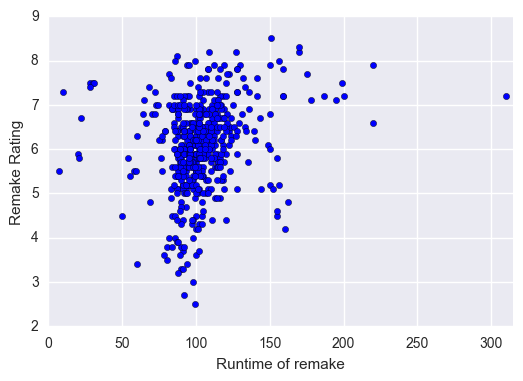

In [21]:
#Now look at relationship between Runtime and IMDB rating

plt.scatter(movies.Runtime_remake, movies.imdbRating_remake)
plt.xlabel('Runtime of remake')
plt.ylabel('Remake Rating')
plt.xlim(0, 315);

In [22]:
#Pearson's correlation of the above
movies.imdbRating_remake.corr(movies.Runtime_remake)

0.22097369758693133

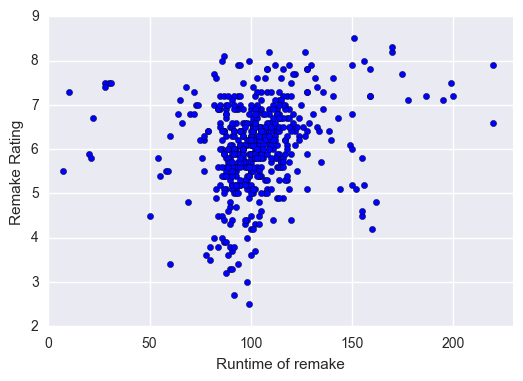

In [23]:
#And without the one large outlier
plt.scatter(movies.Runtime_remake, movies.imdbRating_remake)
plt.xlabel('Runtime of remake')
plt.ylabel('Remake Rating')
plt.xlim(0, 230);

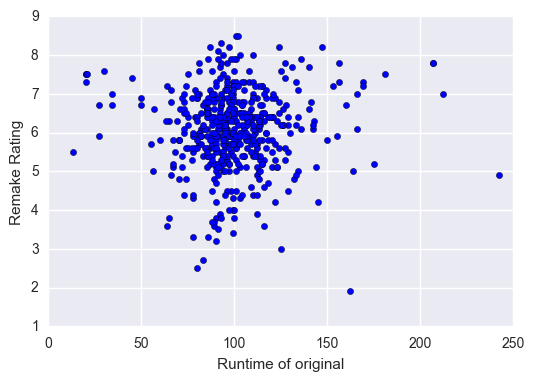

In [24]:
#Next check runtime of original, though it seems less likely to matter

plt.scatter(movies.Runtime_orig, movies.imdbRating_remake)
plt.xlabel('Runtime of original')
plt.ylabel('Remake Rating')
plt.xlim(0, 250);

#Definitely looks more random

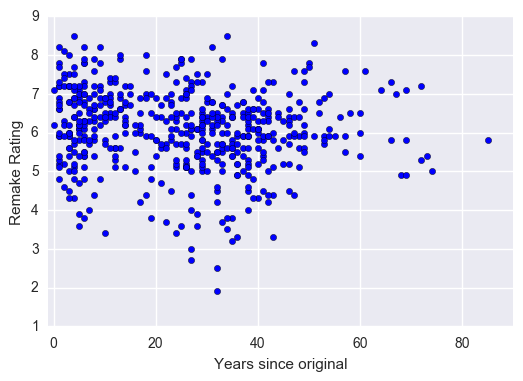

In [25]:
#Examine the effect of years since the original

plt.scatter(movies.YearDiff, movies.imdbRating_remake)
plt.xlabel('Years since original')
plt.ylabel('Remake Rating')
plt.xlim(-1, 90);

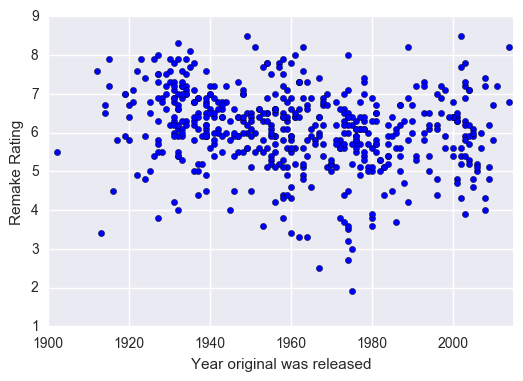

In [26]:
#And the effect of when the original was made

plt.scatter(movies.Year_orig, movies.imdbRating_remake)
plt.xlabel('Year original was released')
plt.ylabel('Remake Rating')
plt.xlim(1900, 2015);

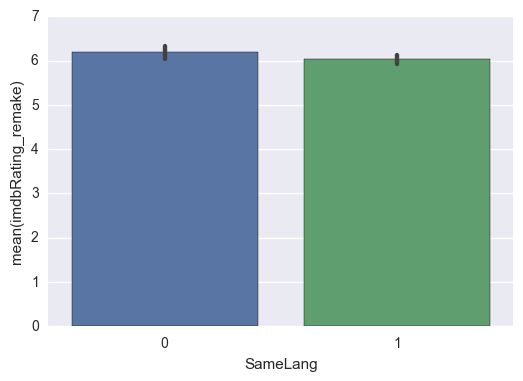

In [27]:
#Compare effect of having the same primary language
sns.barplot(x="SameLang", y="imdbRating_remake", data=movies)

#Not much to see here

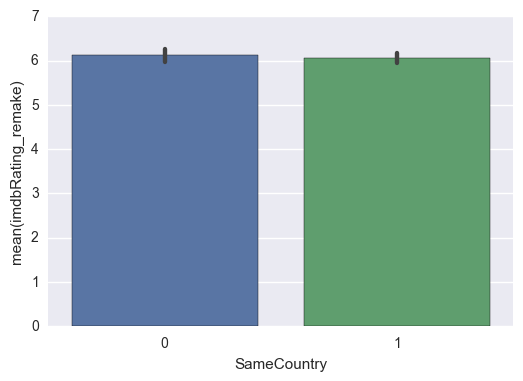

In [28]:
#Compare the effect of being from the same country
sns.barplot(x="SameCountry", y="imdbRating_remake", data=movies)

#Again not much to see

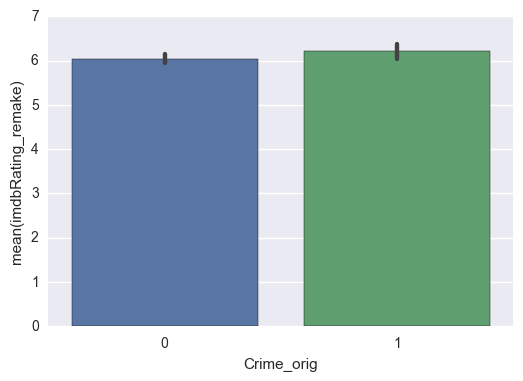

In [29]:
#Finally look at the different possible genres the original could be
sns.barplot(x="Crime_orig", y="imdbRating_remake", data=movies)

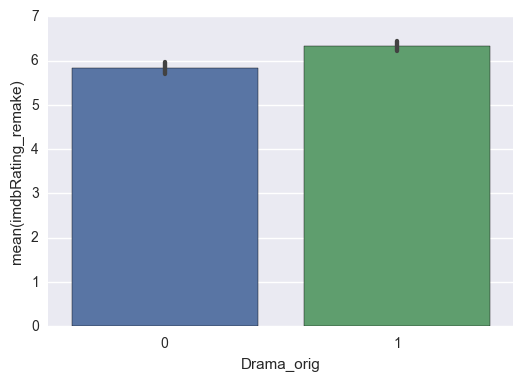

In [30]:
sns.barplot(x="Drama_orig", y="imdbRating_remake", data=movies)

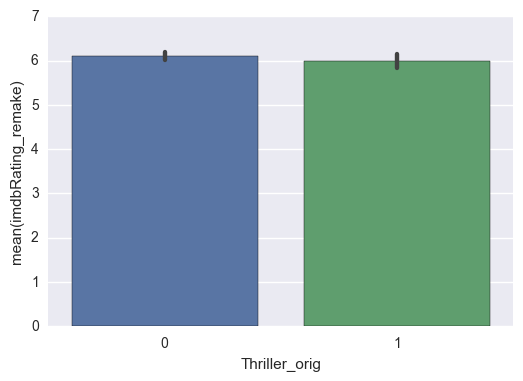

In [31]:
sns.barplot(x="Thriller_orig", y="imdbRating_remake", data=movies)

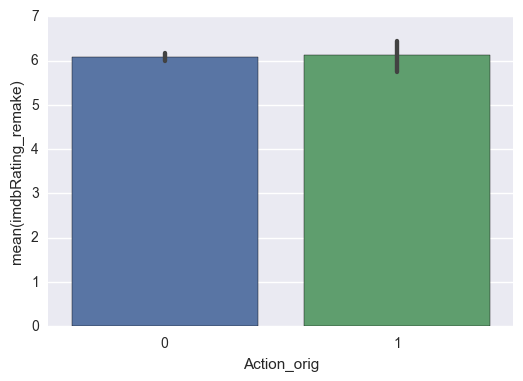

In [32]:
sns.barplot(x="Action_orig", y="imdbRating_remake", data=movies)

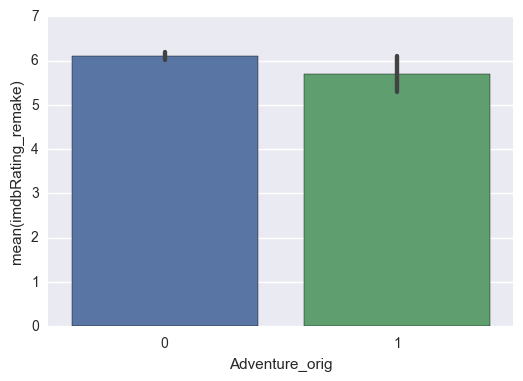

In [33]:
sns.barplot(x="Adventure_orig", y="imdbRating_remake", data=movies)

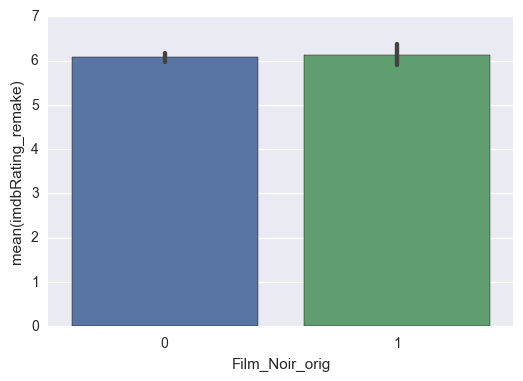

In [34]:
sns.barplot(x="Film_Noir_orig", y="imdbRating_remake", data=movies)

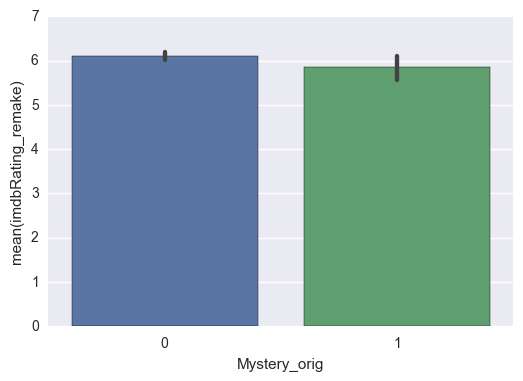

In [35]:
sns.barplot(x="Mystery_orig", y="imdbRating_remake", data=movies)

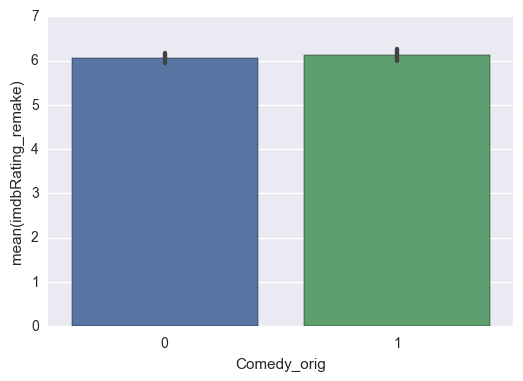

In [36]:
sns.barplot(x="Comedy_orig", y="imdbRating_remake", data=movies)

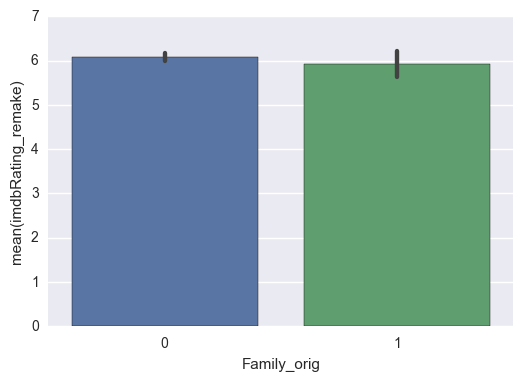

In [37]:
sns.barplot(x="Family_orig", y="imdbRating_remake", data=movies)

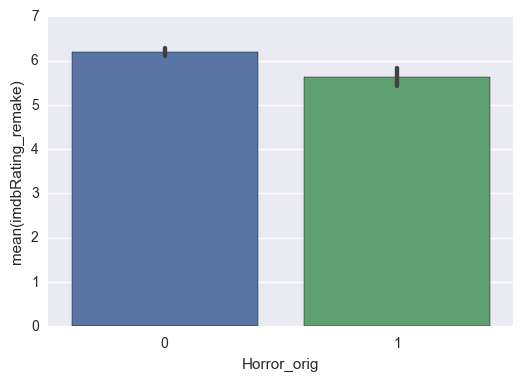

In [38]:
sns.barplot(x="Horror_orig", y="imdbRating_remake", data=movies)

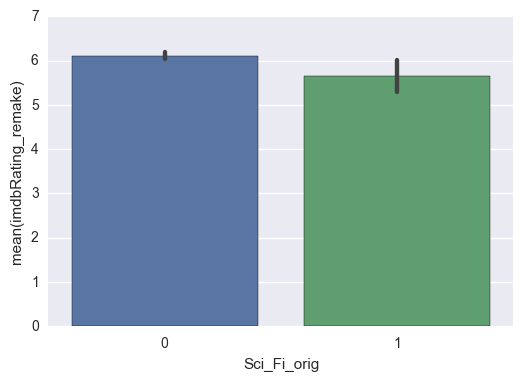

In [39]:
sns.barplot(x="Sci_Fi_orig", y="imdbRating_remake", data=movies)

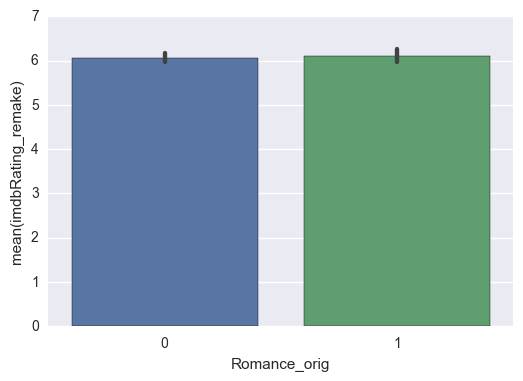

In [40]:
sns.barplot(x="Romance_orig", y="imdbRating_remake", data=movies)

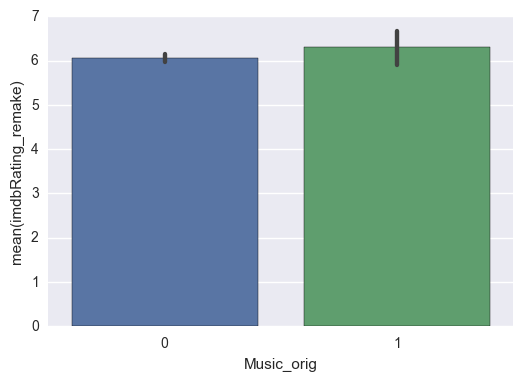

In [41]:
sns.barplot(x="Music_orig", y="imdbRating_remake", data=movies)

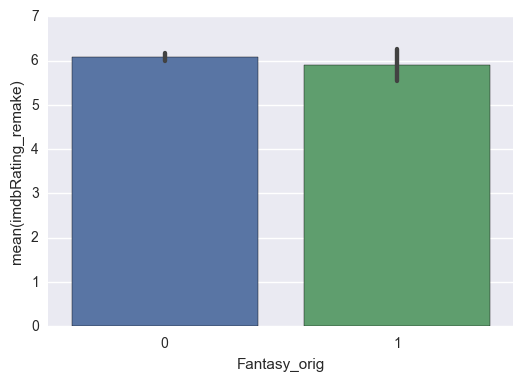

In [42]:
sns.barplot(x="Fantasy_orig", y="imdbRating_remake", data=movies)

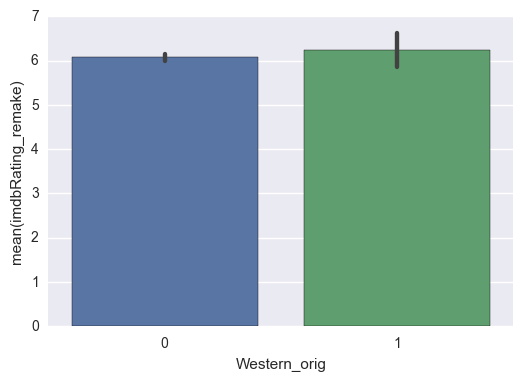

In [43]:
sns.barplot(x="Western_orig", y="imdbRating_remake", data=movies)

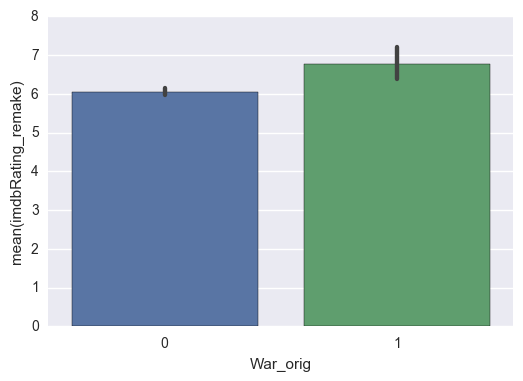

In [44]:
sns.barplot(x="War_orig", y="imdbRating_remake", data=movies)

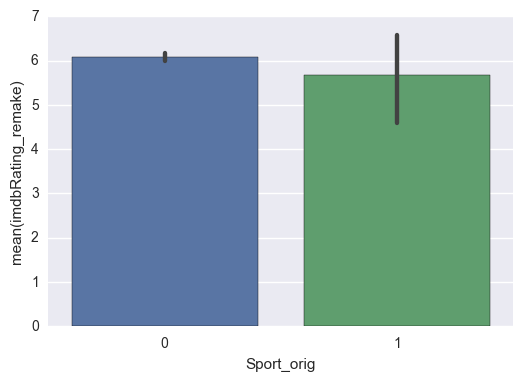

In [45]:
sns.barplot(x="Sport_orig", y="imdbRating_remake", data=movies)

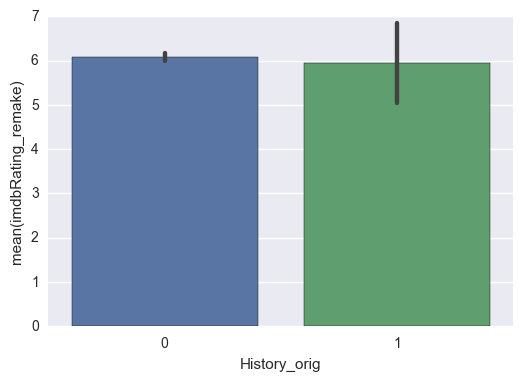

In [46]:
sns.barplot(x="History_orig", y="imdbRating_remake", data=movies)

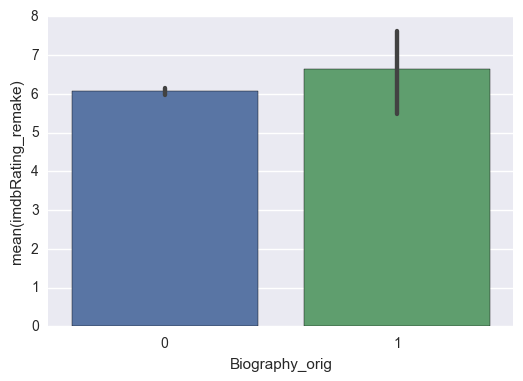

In [47]:
sns.barplot(x="Biography_orig", y="imdbRating_remake", data=movies)

In [48]:
#Statistical analysis
#Create data matrix from most of above variables (dropping missing)
# Note: don't include remake genres since doing so could suppress a meaningful effect of original-film genre
data_matrix = movies[['imdbRating_remake', 'imdbRating_orig', 'Year_orig', 'Award_count_orig', 'Noms_count_orig', 'Noms+Awards_orig', 'Runtime_remake', 'Crime_orig', 'Drama_orig', 'Thriller_orig', 'Action_orig', 'Adventure_orig', 'Film_Noir_orig', 'Mystery_orig', 'Comedy_orig', 'Family_orig', 'Horror_orig', 'Sci_Fi_orig', 'Romance_orig', 'Music_orig', 'Fantasy_orig', 'Western_orig', 'War_orig', 'Sport_orig', 'History_orig', 'Biography_orig', 'SameLang', 'SameCountry', 'YearDiff']].dropna(how='any')

In [49]:
data_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 528
Data columns (total 29 columns):
imdbRating_remake    500 non-null float64
imdbRating_orig      500 non-null float64
Year_orig            500 non-null int64
Award_count_orig     500 non-null int64
Noms_count_orig      500 non-null int64
Noms+Awards_orig     500 non-null int64
Runtime_remake       500 non-null float64
Crime_orig           500 non-null int64
Drama_orig           500 non-null int64
Thriller_orig        500 non-null int64
Action_orig          500 non-null int64
Adventure_orig       500 non-null int64
Film_Noir_orig       500 non-null int64
Mystery_orig         500 non-null int64
Comedy_orig          500 non-null int64
Family_orig          500 non-null int64
Horror_orig          500 non-null int64
Sci_Fi_orig          500 non-null int64
Romance_orig         500 non-null int64
Music_orig           500 non-null int64
Fantasy_orig         500 non-null int64
Western_orig         500 non-null int64
War_orig 

In [50]:
#Add a few new variables 
data_a = data_matrix.copy()
data_b = data_matrix.copy()

#Square of YearDiff (improves certain of the models below)
data_a['YearDiff^2'] = data_matrix['YearDiff']*data_matrix['YearDiff']
data_b['YearDiff^2'] = data_matrix['YearDiff']*data_matrix['YearDiff']

#Natural log of nominations & awards (same models I run below had slightly lower R-squared with the unlogged version)
ln_awards_orig = np.log(1 + data_matrix['Award_count_orig'])
ln_noms_orig = np.log(1 + data_matrix['Noms_count_orig'])
ln_noms_awards_orig = np.log(1 + data_matrix['Noms+Awards_orig'])

data_a = data_a.drop(['Noms_count_orig', 'Award_count_orig', 'Noms+Awards_orig'], axis=1)
data_a['ln_Award_count_orig'] = ln_awards_orig
data_a['ln_Noms_count_orig'] = ln_noms_orig

data_b = data_b.drop(['Noms_count_orig', 'Award_count_orig', 'Noms+Awards_orig'], axis=1)
data_b['ln_Noms+Awards_orig'] = ln_noms_awards_orig

In [51]:
#Start with a classical statistics approach: 
#Look at all these variables, use linear regression, see how well the features explain the variation in ratings of remakes and how they influence those ratings

#Model 1: Use all variables with Nominations and Awards separated
y = data_a.iloc[:, 0]
X1 = data_a.iloc[:, 1:]
model = sm.OLS(y, sm.add_constant(X1))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      imdbRating_remake   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     8.422
Date:                Mon, 09 Jan 2017   Prob (F-statistic):           3.49e-27
Time:                        17:50:08   Log-Likelihood:                -604.88
No. Observations:                 500   AIC:                             1268.
Df Residuals:                     471   BIC:                             1390.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
const                  25.4162      4.663      5.451      0.000        16.253    34.579
imdbRating_orig         0.3420      0.063      5.465      0.000         0.219     0.465
Year_orig              -0.0113      0.002     -4.890      0.000        -0.016    -0.007
Runtime_remake          0.0097      0.002      5.774      0.000         0.006     0.013
Crime_orig              0.0660      0.106      0.623      0.533        -0.142     0.274
Drama_orig              0.2643      0.100      2.637      0.009         0.067     0.461
Thriller_orig           0.1765      0.121      1.455      0.146        -0.062     0.415
Action_orig             0.0679      0.143      0.476      0.635        -0.212     0.348
Adventure_orig         -0.4070      0.151     -2.688      0.007        -0.705    -0.109
Film_Noir_orig         -0.2474      0.197     -1.258      0.209        -0.634     0.139
Mystery_orig           -0.2464      0.133     -1.859      0.064        -0.507     0.014
Comedy_orig             0.0913      0.114      0.800      0.424        -0.133     0.316
Family_orig             0.0291      0.185      0.158      0.875        -0.334     0.392
Horror_orig            -0.2022      0.130     -1.557      0.120        -0.457     0.053
Sci_Fi_orig             0.0010      0.152      0.007      0.995        -0.298     0.300
Romance_orig           -0.2309      0.102     -2.274      0.023        -0.430    -0.031
Music_orig              0.0889      0.185      0.480      0.631        -0.275     0.453
Fantasy_orig           -0.0304      0.148     -0.205      0.838        -0.321     0.261
Western_orig           -0.2602      0.276     -0.942      0.347        -0.803     0.282
War_orig                0.1390      0.247      0.562      0.574        -0.347     0.625
Sport_orig             -0.1175      0.361     -0.326      0.745        -0.826     0.591
History_orig           -0.3922      0.444     -0.882      0.378        -1.265     0.481
Biography_orig          0.3697      0.453      0.816      0.415        -0.521     1.260
SameLang                0.2057      0.152      1.350      0.178        -0.094     0.505
SameCountry            -0.0817      0.114     -0.719      0.473        -0.305     0.142
YearDiff               -0.0409      0.008     -5.242      0.000        -0.056    -0.026
YearDiff^2              0.0004      0.000      3.192      0.002         0.000     0.001
ln_Award_count_orig    -0.0054      0.073     -0.074      0.941        -0.149     0.138
ln_Noms_count_orig     -0.0975      0.065     -1.504      0.133        -0.225     0.030
==============================================================================
Omnibus:                       25.711   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.204
Skew:                         

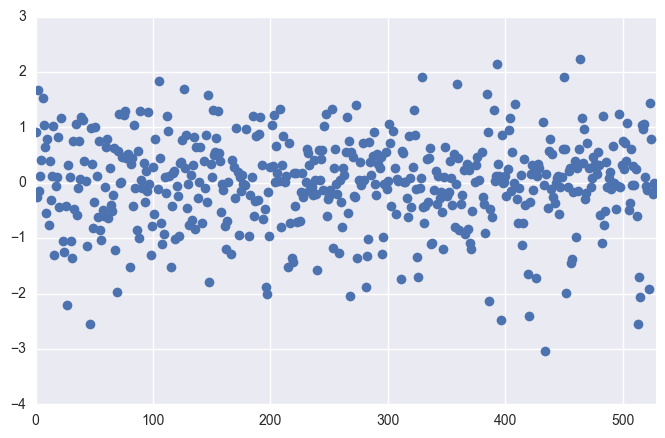

In [52]:
#Plot the residuals
fit.resid.plot(style='o', figsize=(8,5));

In [53]:
#Model 2: Combine nominations & awards instead of treating them separately
y2 = data_b.iloc[:, 0]
X2 = data_b.iloc[:, 1:]
model = sm.OLS(y, sm.add_constant(X2))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      imdbRating_remake   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     8.693
Date:                Mon, 09 Jan 2017   Prob (F-statistic):           1.88e-27
Time:                        17:50:10   Log-Likelihood:                -605.45
No. Observations:                 500   AIC:                             1267.
Df Residuals:                     472   BIC:                             1385.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
const                  25.8026      4.666      5.530      0.000        16.634    34.971
imdbRating_orig         0.3478      0.061      5.656      0.000         0.227     0.469
Year_orig              -0.0115      0.002     -4.984      0.000        -0.016    -0.007
Runtime_remake          0.0097      0.002      5.763      0.000         0.006     0.013
Crime_orig              0.0671      0.106      0.634      0.526        -0.141     0.275
Drama_orig              0.2712      0.099      2.728      0.007         0.076     0.466
Thriller_orig           0.1797      0.121      1.481      0.139        -0.059     0.418
Action_orig             0.0710      0.143      0.498      0.619        -0.209     0.351
Adventure_orig         -0.4027      0.151     -2.659      0.008        -0.700    -0.105
Film_Noir_orig         -0.2460      0.197     -1.251      0.212        -0.633     0.141
Mystery_orig           -0.2468      0.133     -1.862      0.063        -0.507     0.014
Comedy_orig             0.0937      0.114      0.821      0.412        -0.131     0.318
Family_orig             0.0333      0.185      0.180      0.857        -0.330     0.396
Horror_orig            -0.1927      0.130     -1.487      0.138        -0.447     0.062
Sci_Fi_orig             0.0089      0.152      0.059      0.953        -0.289     0.307
Romance_orig           -0.2373      0.101     -2.346      0.019        -0.436    -0.039
Music_orig              0.0878      0.185      0.474      0.636        -0.276     0.452
Fantasy_orig           -0.0330      0.148     -0.223      0.824        -0.324     0.258
Western_orig           -0.2560      0.275     -0.930      0.353        -0.797     0.285
War_orig                0.1418      0.247      0.574      0.567        -0.344     0.627
Sport_orig             -0.1154      0.361     -0.320      0.749        -0.824     0.593
History_orig           -0.3601      0.443     -0.813      0.416        -1.230     0.510
Biography_orig          0.3492      0.453      0.772      0.441        -0.540     1.239
SameLang                0.1836      0.150      1.227      0.220        -0.110     0.478
SameCountry            -0.0732      0.113     -0.647      0.518        -0.296     0.149
YearDiff               -0.0407      0.008     -5.209      0.000        -0.056    -0.025
YearDiff^2              0.0004      0.000      3.165      0.002         0.000     0.001
ln_Noms+Awards_orig    -0.0773      0.045     -1.738      0.083        -0.165     0.010
==============================================================================
Omnibus:                       25.875   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.498
Skew:                          -0.483   Prob(JB):                     1.45e-07
Kurtosis:                       3.762  

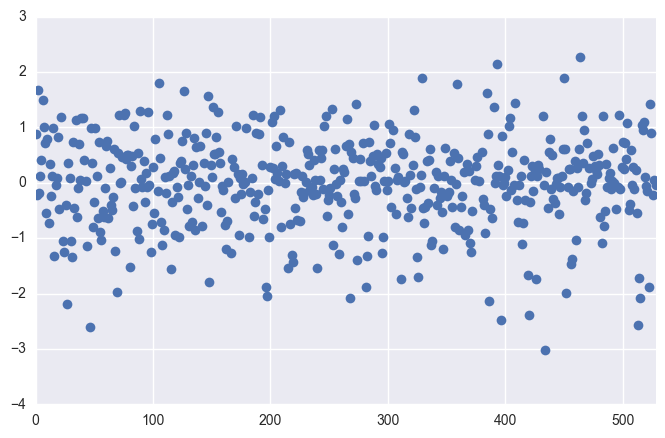

In [54]:
#Plot the residuals
fit.resid.plot(style='o', figsize=(8,5));

In [55]:
#Model 3: Keep both that were important from above and those I expected to be important but weren't; want to show those results
#For the genres, keep those that were significant and those that were close, if the barplot above suggested a meaningful effect 
# (since including so many vars could suppress a true effect)

data_c = data_b.drop(['Crime_orig', 'Action_orig', 'Film_Noir_orig', 'Comedy_orig', 'Family_orig', 'Sci_Fi_orig', 'Music_orig', 'Fantasy_orig', 'Western_orig', 
                      'War_orig', 'Sport_orig', 'History_orig', 'Thriller_orig', 'Biography_orig'], axis=1)

data_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 528
Data columns (total 14 columns):
imdbRating_remake      500 non-null float64
imdbRating_orig        500 non-null float64
Year_orig              500 non-null int64
Runtime_remake         500 non-null float64
Drama_orig             500 non-null int64
Adventure_orig         500 non-null int64
Mystery_orig           500 non-null int64
Horror_orig            500 non-null int64
Romance_orig           500 non-null int64
SameLang               500 non-null int64
SameCountry            500 non-null int64
YearDiff               500 non-null int64
YearDiff^2             500 non-null int64
ln_Noms+Awards_orig    500 non-null float64
dtypes: float64(4), int64(10)
memory usage: 58.6 KB


In [56]:
#Model 3
y3 = data_c.iloc[:, 0]
X3 = data_c.iloc[:, 1:]

model = sm.OLS(y3, sm.add_constant(X3))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      imdbRating_remake   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     17.70
Date:                Mon, 09 Jan 2017   Prob (F-statistic):           1.25e-33
Time:                        17:50:13   Log-Likelihood:                -609.46
No. Observations:                 500   AIC:                             1247.
Df Residuals:                     486   BIC:                             1306.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
const                  23.9372      4.388      5.455      0.000        15.316    32.559
imdbRating_orig         0.3576      0.059      6.043      0.000         0.241     0.474
Year_orig              -0.0105      0.002     -4.862      0.000        -0.015    -0.006
Runtime_remake          0.0095      0.002      5.913      0.000         0.006     0.013
Drama_orig              0.2228      0.082      2.714      0.007         0.062     0.384
Adventure_orig         -0.4388      0.139     -3.154      0.002        -0.712    -0.165
Mystery_orig           -0.2674      0.126     -2.122      0.034        -0.515    -0.020
Horror_orig            -0.2236      0.107     -2.096      0.037        -0.433    -0.014
Romance_orig           -0.2612      0.092     -2.830      0.005        -0.443    -0.080
SameLang                0.1716      0.143      1.204      0.229        -0.108     0.452
SameCountry            -0.0759      0.111     -0.684      0.495        -0.294     0.142
YearDiff               -0.0395      0.008     -5.214      0.000        -0.054    -0.025
YearDiff^2              0.0004      0.000      3.106      0.002         0.000     0.001
ln_Noms+Awards_orig    -0.0719      0.043     -1.677      0.094        -0.156     0.012
==============================================================================
Omnibus:                       29.359   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.385
Skew:                          -0.522   Prob(JB):                     1.26e-08
Kurtosis:                       3.809   Cond. No.                     2.65e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

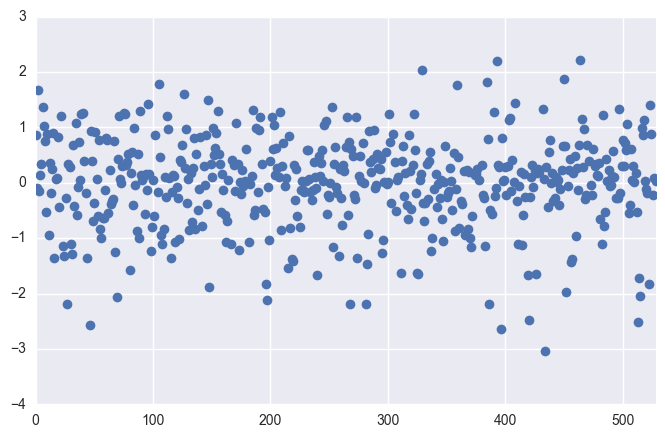

In [57]:
#Plot the residuals
fit.resid.plot(style='o', figsize=(8,5));

In [58]:
#Now turn to cross-validation & out-of-sample prediction. How different would the model look if I built it explicitly to help film-makers
#predict favorability of potential future remakes based on the performance of past remakes?

#Use LassoCV to find best alpha & identify best subset of features to avoid overfit & maximize accuracy for out-of-sample data
#First use all the data for the cross-validation, since this is a lot of variables for relatively few observations

lasso=LassoCV(max_iter=2000,cv=10)
lasso.fit(X2, y)
print 'R^2 score: ', (lasso.score(X2, y2))
print 'Alpha: ', lasso.alpha_
pd.DataFrame(zip(X2.columns, lasso.coef_))

R^2 score:  0.26074219153
Alpha:  0.08231392


,0,1
0,imdbRating_orig,0.203433
1,Year_orig,-0.013847
2,Runtime_remake,0.010894
3,Crime_orig,0.000000
4,Drama_orig,0.000000
5,Thriller_orig,0.000000
6,Action_orig,0.000000
7,Adventure_orig,-0.000000
8,Film_Noir_orig,-0.000000
9,Mystery_orig,-0.000000


In [59]:
#Now try the LassoCV on most of the data and test it on a hold-out test set

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

lasso=LassoCV(max_iter=2000,cv=10)
lasso.fit(X2_train, y2_train)
print 'Alpha: ', lasso.alpha_
print 'R^2 score on test set: ', (lasso.score(X2_test, y2_test))
pd.DataFrame(zip(X2.columns, lasso.coef_))

Alpha:  0.145049044898
R^2 score on test set:  0.150143125252


,0,1
0,imdbRating_orig,0.028414
1,Year_orig,-0.014560
2,Runtime_remake,0.011433
3,Crime_orig,0.000000
4,Drama_orig,0.000000
5,Thriller_orig,0.000000
6,Action_orig,0.000000
7,Adventure_orig,-0.000000
8,Film_Noir_orig,-0.000000
9,Mystery_orig,-0.000000


In [60]:
#Both Lasso versions suggest the same 5 variables to keep: here's how that looks with a simple train-test-split

data_d = data_c[['imdbRating_remake', 'imdbRating_orig', 'Year_orig', 'Runtime_remake', 'YearDiff', 'YearDiff^2']]

y4 = data_d.iloc[:, 0]
X4 = data_d.iloc[:, 1:]

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.4, random_state=42)

#Run & fit model:
lr = LinearRegression()
lr.fit(X4_train, y4_train)
y4_pred = lr.predict(X4_test)

#R^2 for the test set
print 'R^2 score, test set: ', metrics.r2_score(y4_test, y4_pred)

R^2 score, test set:  0.256342522291


In [61]:
#Compare: here's how it looks with a simple train-test-split using the original Model 3 
#NOTE: they are almost identical...

X5_train, X5_test, y5_train, y5_test = train_test_split(X3, y3, test_size=0.4, random_state=42)

#Run & fit model:
lr = LinearRegression()
lr.fit(X5_train, y5_train)
y5_pred = lr.predict(X5_test)

#R^2 for the test set
print 'R^2 score, test set: ', metrics.r2_score(y5_test, y5_pred)

R^2 score, test set:  0.254225184706


In [62]:
#Can I do better somewhere in between?
#Yes - with this simpler cross-validation, all the originally significant genres and Noms&Awards improve out-of-sample performance:

data_e = data_c[['imdbRating_remake', 'imdbRating_orig', 'Year_orig', 'Runtime_remake', 'YearDiff', 'YearDiff^2', 'Drama_orig', 'Adventure_orig', 'Mystery_orig',
                 'Romance_orig', 'ln_Noms+Awards_orig']]

y6 = data_e.iloc[:, 0]
X6 = data_e.iloc[:, 1:]

X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size=0.4, random_state=42)

#Run & fit model:
lr = LinearRegression()
lr.fit(X6_train, y6_train)
y6_pred = lr.predict(X6_test)

#And look at the r^2 for how it does on the test set
print 'R^2 score, test set: ', metrics.r2_score(y6_test, y6_pred)

R^2 score, test set:  0.292971806289


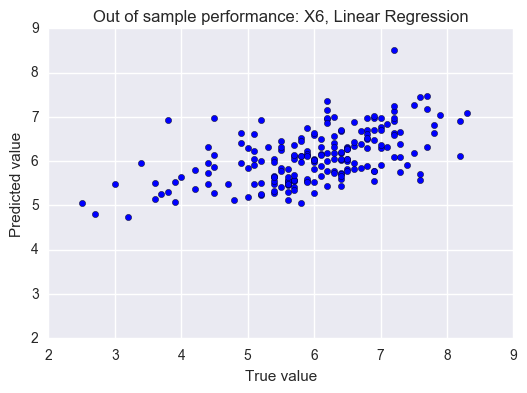

In [63]:
#Plot true values vs. predictions
plt.scatter(y6_test, y6_pred)
plt.xlim(2,9)
plt.ylim(2,9)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('Out of sample performance: X6, Linear Regression');

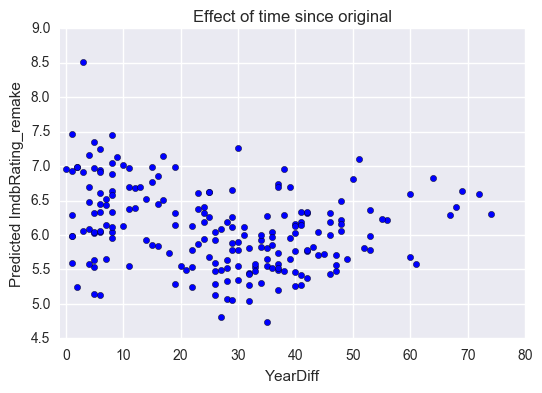

In [64]:
#What does the relationship between the predictions and YearDiff look like, given the quadratic term?
plt.scatter(X6_test.YearDiff, y6_pred)
plt.xlabel('YearDiff')
plt.ylabel('Predicted ImdbRating_remake')
plt.title('Effect of time since original')
plt.xlim(-1,80);

In [65]:
#Next try Random Forest, using all 3 of the above feature combinations (X4, X5, X6)
#Use 60% of data with grid search to tune the hyperparameters, save 40% for testing out-of-sample predictions

param_grid = {"max_depth": [4, 5, 6, 7, 8],
              "n_estimators": [30, 40, 50, 60],
              "min_samples_leaf": [5, 10, 15, 20]}

In [66]:
# Gridsearch RF with X4 ('imdbRating_remake', 'imdbRating_orig', 'Year_orig', 'Runtime_remake', 'YearDiff', 'YearDiff^2')

rf = RandomForestRegressor(n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=10)
grid_search.fit(X4_train, y4_train)

print 'Best parameters set: ', grid_search.best_params_

y4_rf_pred = grid_search.predict(X4_test)
print 'R^2 Score on test set: ', metrics.r2_score(y4_test, y4_rf_pred)

Best parameters set:  {'n_estimators': 60, 'max_depth': 6, 'min_samples_leaf': 15}
R^2 Score on test set:  0.224581783693


In [67]:
# Gridsearch RF with X5 (Everything in the original Model 3)

rf = RandomForestRegressor(n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=10)
grid_search.fit(X5_train, y5_train)

print 'Best parameters set: ', grid_search.best_params_

y5_rf_pred = grid_search.predict(X5_test)
print 'R^2 Score on test set: ', metrics.r2_score(y5_test, y5_rf_pred)

Best parameters set:  {'n_estimators': 60, 'max_depth': 8, 'min_samples_leaf': 5}
R^2 Score on test set:  0.192723435942


In [68]:
#Gridsearch RF with X6 ('imdbRating_remake', 'imdbRating_orig', 'Year_orig', 'Runtime_remake', 'YearDiff', 'YearDiff^2', 'Drama_orig', 'Adventure_orig', 'Mystery_orig',
#                 'Romance_orig', 'ln_Noms+Awards_orig')

rf = RandomForestRegressor(n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=10)
grid_search.fit(X6_train, y6_train)

print 'Best parameters set: ', grid_search.best_params_

y6_rf_pred = grid_search.predict(X6_test)
print 'R^2 Score on test set: ', metrics.r2_score(y6_test, y6_rf_pred)

Best parameters set:  {'n_estimators': 60, 'max_depth': 8, 'min_samples_leaf': 20}
R^2 Score on test set:  0.225548678923


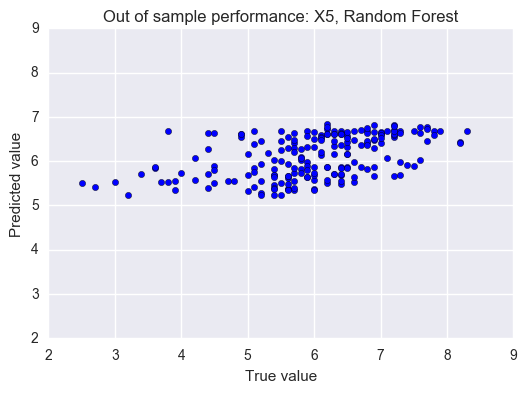

In [69]:
plt.scatter(y6_test, y6_rf_pred)
plt.xlim(2,9)
plt.ylim(2,9)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('Out of sample performance: X5, Random Forest');

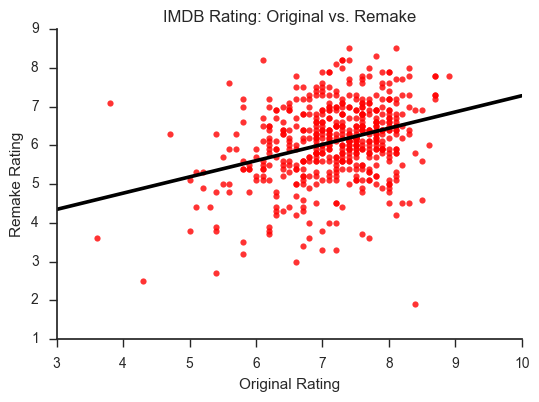

In [70]:
#Make a graph of imdbRating_orig vs. imdbRating_remake to show in the blog post
sns.set(style="ticks")
ax = sns.regplot(movies.imdbRating_orig, movies.imdbRating_remake, ci=False, scatter_kws={"color":"red"},
    line_kws={"color":"black"})
sns.despine()

ax.figure.set_size_inches(6,4)
ax.axes.set_title("IMDB Rating: Original vs. Remake")
ax.set_xlabel("Original Rating")
ax.set_ylabel("Remake Rating");
fig = ax.get_figure()
fig.savefig('figures/ratings_orig_vs_remake.png')

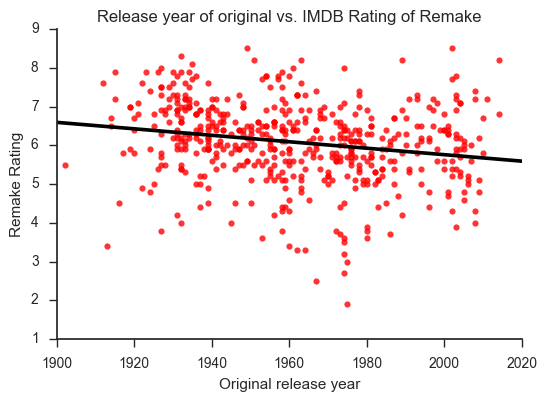

In [71]:
#Make a graph of Year_orig vs. imdbRating_remake to show in the blog post
ax = sns.regplot(movies.Year_orig, movies.imdbRating_remake, ci=False, scatter_kws={"color":"red"},
    line_kws={"color":"black"})
sns.despine()

ax.figure.set_size_inches(6,4)
ax.axes.set_title("Release year of original vs. IMDB Rating of Remake")
ax.set_xlabel("Original release year")
ax.set_ylabel("Remake Rating")
ax.set_xlim(1900, 2020);
fig = ax.get_figure()
fig.savefig('figures/year_orig_vs_remake_rating.png')